# Data Exploration and Dataset re-build 

In [98]:
import os
from query_tool import M100DataClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
from datetime import timedelta

plt.style.use("seaborn-v0_8")

DATASET_FOLDER = "./dataset/"
DATASET_FOLDER_ORIGINAL = DATASET_FOLDER + "original/"
DATASET_FOLDER_REBUILD = DATASET_FOLDER + "rebuild/"

DISPLAY_GRAPHS = False

YEAR = 2022
MONTH = 9

NAGIOS_TIME_DELTA_MINS = 15

date_dataset = datetime(YEAR, MONTH, 1)

dataset_rebuild_path = DATASET_FOLDER_REBUILD + date_dataset.strftime("%y-%m")
os.makedirs(dataset_rebuild_path, exist_ok=True)


dataset_path = (
    DATASET_FOLDER_ORIGINAL + date_dataset.strftime("%y-%m") + "/year_month=" + date_dataset.strftime("%y-%m")
)
dataset_path

'./dataset/original/22-09/year_month=22-09'

In [99]:
client = M100DataClient(dataset_path)

In [100]:
# Create array of days for graphs
# [2022-09-01, 2022-09-02, 2022-09-03, ...]
xticks_days = [
    date_dataset.replace(day=i).strftime("%Y-%m-%d")
    for i in range(1, calendar.monthrange(date_dataset.year, date_dataset.month)[1] + 1)
]

In [101]:
# Detect non numerical features
all_non_numerical_features = {
    key: value
    for key, value in client.dtype_per_metric.items()
    if not any(t in str(value) for t in ["float", "int", "double"])
}
all_non_numerical_features

{'machine_type': DataType(string),
 'gexec': DataType(string),
 'os_name': DataType(string),
 'os_release': DataType(string),
 'Prototype': DataType(string),
 'address': DataType(string),
 'Gateway': DataType(string),
 'job_info_marconi100': None}

In [102]:
def _metrics_description(plugin):
    print("Plugin: '{}'".format(plugin))
    for metric in client.metrics_per_plugin[plugin]:
        print("metric: '{}'".format(metric))
        print("\tdtype:", client.dtype_per_metric[metric])
        print("\ttags:", client.tags_per_metric[metric])
    print("----------------------------------------------------------------")
    non_numerical = list(
        metric for metric in client.metrics_per_plugin[plugin] if metric in all_non_numerical_features.keys()
    )
    print(
        "NON NUMERICAL METRICS:",
        non_numerical,
    )
    return non_numerical

# Nodes with the most data available 

In [103]:
%%script false --no-raise-error

highest_nodeID = 1162
nodes_rows = pd.DataFrame({"rows": [0] * highest_nodeID}, dtype=int)
fill_na_rows = pd.DataFrame({"node": range(0, highest_nodeID + 1, 1)}, dtype=int)

for plugin, metrics in all_metrics.items():
    for met in metrics:
        # Create dataset with {nodeID, number of rows of the metric}
        results = (
            client.query(metrics=[met], columns=["node"])
            .groupby("node", observed=False)
            .size()
            .reset_index(name="rows")
            .astype({"node": int})
            .sort_values("node")
            .reset_index(drop=True)
        )
        results = pd.merge(fill_na_rows, results, on="node", how="left")
        nodes_rows["rows"] += results["rows"].fillna(0)

display(
    nodes_rows.sort_values(by="rows", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
)

# # Results:
# 3	    28246529
# 1	    28246382
# 2	    28243448
# 0	    28219495
# 880	27026042
# 703	27023216
# 334	27020755
# 41	27011895
# 961	27008536
# 585	27003582

# Nodes with most Nagios anomalies

In [104]:
%%script false --no-raise-error
results = (
    client.query_plugins(plugins=["nagios"], columns=["node", "value"])
    .query("value in [1,2,3]")
    .groupby("node", observed=False)
    .size()
    .reset_index(name="rows")
    .astype({"node": int})
    .sort_values("node")
    .reset_index(drop=True)
)

results = nodes_rows.iloc[
    results.sort_values(by="rows", ascending=False).iloc[0:10, 0].values, :
]

display(
    results.sort_values(by="rows", ascending=False)
    .head(10)
    .style.set_caption("Nodes with most data available")
)

# Results
# 19	26281005
# 949	25556767
# 298	25544516
# 322	24589350
# 38	24106684
# 335	24094853
# 10	23496599
# 1007	52237
# 1008	10668
# 1002	5334

In [105]:
# good examples: 10, 38, 335
NODE_SELECTED = "10"

In [106]:
%reset_selective -f ^date_dataset$
%reset_selective -f ^YEAR$
%reset_selective -f ^MONTH$
%reset_selective -f ^DATASET_FOLDER$
%reset_selective -f ^plugins$

---
# Nagios

In [107]:
_metrics_description("nagios")

Plugin: 'nagios'
metric: 'state'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'description', 'host_group', 'nagiosdrained', 'node', 'state_type']
----------------------------------------------------------------
NON NUMERICAL METRICS: []


[]

In [108]:
df_nagios = client.query_plugins(plugins="nagios", node=NODE_SELECTED).sort_values(by="timestamp", ascending=True)

df_nagios.info()
display(df_nagios.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 40005 entries, 0 to 25841
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   year_month     0 non-null      category           
 1   plugin         40005 non-null  category           
 2   metric         40005 non-null  category           
 3   host_group     40005 non-null  category           
 4   state_type     40005 non-null  string             
 5   timestamp      40005 non-null  datetime64[ms, UTC]
 6   nagiosdrained  40005 non-null  string             
 7   description    40005 non-null  category           
 8   node           40005 non-null  category           
 9   value          40005 non-null  Int32              
dtypes: Int32(1), category(6), datetime64[ms, UTC](1), string(2)
memory usage: 1.8 MB


,year_month,plugin,metric,host_group,state_type,timestamp,nagiosdrained,description,node,value
0,NaN,nagios_pub,state,"idmtest,compute",1,2022-09-01 00:00:00+00:00,0,alive::ping,10,0
176,NaN,nagios_pub,state,"idmtest,compute",1,2022-09-01 00:00:00+00:00,0,batchs::client,10,0
264,NaN,nagios_pub,state,"idmtest,compute",1,2022-09-01 00:00:00+00:00,0,filesys::eurofusion::mount,10,0


In [109]:
# Keep only useful columns
df_nagios = df_nagios[["description", "value", "timestamp", "nagiosdrained"]]
descriptions = df_nagios["description"].sort_values().unique()

In [110]:
# Display graphs
if DISPLAY_GRAPHS:
    for descr in descriptions:
        _, axes = plt.subplots(figsize=(16, 3))
        df_nagios_plot = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "value", "nagiosdrained"]]
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["value"], label="state")
        axes.plot(df_nagios_plot["timestamp"], df_nagios_plot["nagiosdrained"].astype(int), label="nagiosdrained")
        axes.set_title("{}\n {}\n (node {})".format("nagios", descr, NODE_SELECTED))
        axes.legend()
        axes.set_xticks(xticks_days), axes.set_yticks([0, 1, 2, 3])
        axes.tick_params(axis="x", labelrotation=45)
        plt.tight_layout()
        plt.show()

## Verifications

In [111]:
# Verify that the timestamps of all the descriptions are equal
is_equal_descr = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
for descr in descriptions[1:]:
    is_equal_descr = (
        is_equal_descr
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["timestamp"]).all()
    )
if not is_equal_descr:
    raise Exception("Not all description timestamps are equal")

In [112]:
# Verify that "nagiosdrained" of all the descriptions are equal
is_equal_nagios_drained = True
df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["nagiosdrained"]
for descr in descriptions:
    is_equal_nagios_drained = (
        is_equal_nagios_drained
        and (df_temp == df_nagios.loc[df_nagios["description"] == descr].reset_index()["nagiosdrained"]).all()
    )

if not is_equal_nagios_drained:
    raise Exception("Not all description nagiosdrained are equal")

In [113]:
# Verify that the timestamps are equally spaced and that there are no time holes.
# Take only the timestamps of one description since they're all equal


def check_timestamps(timestamps):
    ts_temp = None
    for ts in timestamps:
        if ts_temp != None:
            if ts - ts_temp != timedelta(minutes=NAGIOS_TIME_DELTA_MINS):
                missing_intervals = (ts - ts_temp) // timedelta(minutes=NAGIOS_TIME_DELTA_MINS) - 1
                print(
                    "There is a time hole of {} timestamps, between these *present* timestamps: \n {}\n {}\n".format(
                        missing_intervals, ts_temp, ts
                    )
                )
        ts_temp = ts


df_temp = df_nagios.loc[df_nagios["description"] == descriptions[0]].reset_index()["timestamp"]
check_timestamps(df_temp)

There is a time hole of 3 timestamps, between these *present* timestamps: 
 2022-09-12 20:30:00+00:00
 2022-09-12 21:30:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-13 08:15:00+00:00
 2022-09-13 09:00:00+00:00

There is a time hole of 5 timestamps, between these *present* timestamps: 
 2022-09-13 09:45:00+00:00
 2022-09-13 11:15:00+00:00

There is a time hole of 1 timestamps, between these *present* timestamps: 
 2022-09-13 12:30:00+00:00
 2022-09-13 13:00:00+00:00

There is a time hole of 2 timestamps, between these *present* timestamps: 
 2022-09-20 08:45:00+00:00
 2022-09-20 09:30:00+00:00



## Build the new dataframe

In [114]:
df_nagios_rebuild = pd.DataFrame()

# Downcast to int8 for space reasons
df_nagios["nagiosdrained"] = pd.to_numeric(df_nagios["nagiosdrained"], downcast="integer")
df_nagios["value"] = pd.to_numeric(df_nagios["value"], downcast="integer")


for descr in descriptions:
    df_temp = df_nagios.loc[df_nagios["description"] == descr][["timestamp", "nagiosdrained", "value"]].rename(
        columns={"value": str(descr)}
    )
    if df_nagios_rebuild.empty:
        df_nagios_rebuild = df_temp
    else:
        df_nagios_rebuild = pd.merge(df_nagios_rebuild, df_temp, on=["timestamp", "nagiosdrained"])

df_nagios_rebuild = df_nagios_rebuild.set_index("timestamp")

display(df_nagios_rebuild.head(3))
df_nagios_rebuild.info()

,nagiosdrained,alive::ping,batchs::client::state,batchs::client,bmc::events,filesys::eurofusion::mount,filesys::local::avail,filesys::local::mount,memory::phys::total,net::ib::status,nvidia::configuration,nvidia::memory::replace,nvidia::memory::retirement,ssh::daemon,sys::rvitals,sys::gpfs::status
timestamp,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-09-01 00:15:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-09-01 00:30:00+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   nagiosdrained               2667 non-null   Int8 
 1   alive::ping                 2667 non-null   Int8 
 2   batchs::client::state       2667 non-null   Int8 
 3   batchs::client              2667 non-null   Int8 
 4   bmc::events                 2667 non-null   Int8 
 5   filesys::eurofusion::mount  2667 non-null   Int8 
 6   filesys::local::avail       2667 non-null   Int8 
 7   filesys::local::mount       2667 non-null   Int8 
 8   memory::phys::total         2667 non-null   Int8 
 9   net::ib::status             2667 non-null   Int8 
 10  nvidia::configuration       2667 non-null   Int8 
 11  nvidia::memory::replace     2667 non-null   Int8 
 12  nvidia::memory::retirement  2667 non-null   Int8 
 13  ssh::daemon    

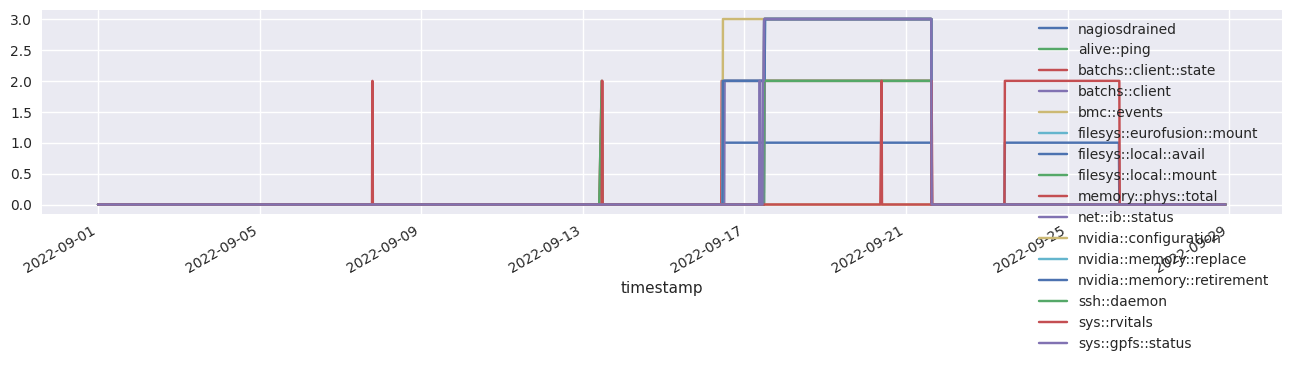

In [115]:
_, axes = plt.subplots(figsize=(16, 3))
df_nagios_rebuild.plot(ax=axes)
plt.show()

In [116]:
# Save rebuilt dataframe
df_nagios_rebuild.to_csv(dataset_rebuild_path + "/nagios_rebuild_node:" + NODE_SELECTED + ".csv", index=True)

In [117]:
# Extract valuable information
nagios_sample_number = df_nagios_rebuild.shape[0]
nagios_initial_timestamp, nagios_final_timestamp = (
    df_nagios_rebuild.idxmax(),
    df_nagios_rebuild.idxmin(),
)

In [118]:
%reset_selective -f ^df_
%reset_selective -f ^descr
%reset_selective -f ^ax
%reset_selective -f ^is_equal_

---
# Ganglia Metric

In [119]:
non_numerical_features = _metrics_description(plugin="ganglia")

Plugin: 'ganglia'
metric: 'Gpu2_fb_used'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu3_power_management_limit'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu1_ecc_sbe_aggregate_total'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu3_gpu_utilization'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu3_sm_app_clock'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu1_retired_pages_sbe'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu0_power_usage'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'cpu_wio'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'Gpu0_board_limit_violation'
	dtype: int32
	tags:

In [120]:
df_ganglia: pd.DataFrame = (
    client.query_plugins(plugins="ganglia", node=NODE_SELECTED)
    .sort_values(by="timestamp", ascending=True)
    .reset_index(drop=True)
)

df_ganglia.info()
display(df_ganglia.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12909075 entries, 0 to 12909074
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   timestamp   datetime64[ms, UTC]
 2   plugin      category           
 3   node        category           
 4   metric      category           
 5   value       object             
dtypes: category(4), datetime64[ms, UTC](1), object(1)
memory usage: 270.9+ MB


,year_month,timestamp,plugin,node,metric,value
0,NaN,2022-09-01 00:00:01+00:00,ganglia_pub,10,os_name,Linux
1,NaN,2022-09-01 00:00:01+00:00,ganglia_pub,10,boottime,1660034661.0
2,NaN,2022-09-01 00:00:01+00:00,ganglia_pub,10,machine_type,powerpc


In [121]:
# Remove metrics that don't change in value
def remove_non_changing_metrics(df):
    to_remove = []
    for metric in df["metric"].sort_values().unique():
        df_temp = df.loc[df["metric"] == metric]
        if (df_temp["value"] == df_temp["value"].tolist()[0]).all():
            to_remove.append(metric)
    return df.loc[~df["metric"].isin(to_remove)].reset_index(drop=True)


df_ganglia = remove_non_changing_metrics(df_ganglia)

In [122]:
# Distinct values for non-numerical metrics
def detect_distinct_non_numerical_values(df):
    print("Distinct values for non-numerical metrics: ")
    for feature in non_numerical_features:
        if feature in df["metric"].values:
            distinct_values = df.loc[df["metric"] == feature]["value"].unique()
            print("Distinct values for metric '{}': {}".format(feature, distinct_values))
            if len(distinct_values) > 1:
                raise Exception("There are more than one distinct values for metric '{}'.".format(feature))


detect_distinct_non_numerical_values(df_ganglia)

Distinct values for non-numerical metrics: 


In [123]:
# Keep only useful columns
df_ganglia = df_ganglia[["timestamp", "value", "metric"]].reset_index(drop=True)

metrics = df_ganglia["metric"].sort_values().unique()

In [124]:
if DISPLAY_GRAPHS:
    # Divide into different categories
    ganglia_metrics_available = df_ganglia["metric"].unique()
    ganglia_metrics_dict = {
        "gpu0": [s for s in ganglia_metrics_available if s.startswith("Gpu0")],
        "gpu1": [s for s in ganglia_metrics_available if s.startswith("Gpu1")],
        "gpu2": [s for s in ganglia_metrics_available if s.startswith("Gpu2")],
        "gpu3": [s for s in ganglia_metrics_available if s.startswith("Gpu3")],
        "system": [s for s in ganglia_metrics_available if s in ["boottime", "machine_type", "os_name", "os_release"]],
        "network": [s for s in ganglia_metrics_available if s in ["bytes_in", "bytes_out", "pkts_in", "pkts_out"]],
        "cpu": [s for s in ganglia_metrics_available if s.startswith("cpu")],
        "disk": [s for s in ganglia_metrics_available if s.startswith("disk") or s in ["part_max_used"]],
        "core": [s for s in ganglia_metrics_available if s in ["gexec"]],
        "load": [s for s in ganglia_metrics_available if s.startswith("load")],
        "memory": [s for s in ganglia_metrics_available if s.startswith("mem") or s.startswith("swap")],
        "process": [s for s in ganglia_metrics_available if s.startswith("proc")],
    }

In [125]:
from sklearn.preprocessing import MinMaxScaler

if DISPLAY_GRAPHS:
    for metric_name, val in ganglia_metrics_dict.items():
        _, axes = plt.subplots(figsize=(16, 5))
        empty = True
        for met in val:
            df_metric = df_ganglia.loc[df_ganglia["metric"] == met][["timestamp", "value"]]

            # Remove metrics with unmuted values
            # if (df_metric["value"] == df_metric["value"].tolist()[0]).all():
            #     continue

            # Remove metrics non numerical
            # if ~df_metric["value"].apply(lambda x: pd.to_numeric(x, errors="coerce")).notnull().all():
            #     continue

            empty = False

            # Scaling for plotting
            df_metric["value"] = MinMaxScaler().fit_transform(df_metric[["value"]].astype(float))
            axes.scatter(df_metric["timestamp"], df_metric["value"], label=met)
            axes.set_title("{} - (node {})".format(metric_name, NODE_SELECTED))
            axes.set_xticks(xticks_days)
            axes.legend(loc="upper left")
            axes.tick_params(axis="x", labelrotation=45)

        if empty:
            axes.remove()
        plt.tight_layout()
        plt.show()

## Verifications

In [126]:
# Null rows
if df_ganglia.shape[0] - df_ganglia.dropna().shape[0] != 0:
    raise Exception("There are null rows in the ganglia dataframe")

In [127]:
# Number of samples per metric
def samples_per_metric(df):
    print(
        f"Total samples of nagios plugin: {nagios_sample_number} with timedelta of {timedelta(minutes=NAGIOS_TIME_DELTA_MINS)}\n"
    )
    print("Total samples per metric:")
    list_temp = []
    for metric in metrics:
        df_temp = df.loc[df["metric"] == metric].reset_index()

        df_temp["timedelta"] = df_temp["timestamp"].diff().dt.total_seconds()

        list_temp.append(
            [
                df_temp["timestamp"].shape[0],
                len(df_temp["value"].unique()),
                metric,
                str(timedelta(seconds=df_temp["timedelta"].mean())),
                str(timedelta(seconds=df_temp["timedelta"].median())),
                str(timedelta(seconds=df_temp["timedelta"].max())),
                [df_temp["timestamp"].min(), df_temp["timestamp"].max()],
            ]
        )
    list_temp.sort(reverse=True)

    for n, u, m, mean, median, mode, ts in list_temp:
        print(
            f"{n} \t of which unique {u}\t for metric '{m}'\n\t\t with timedelta | MEAN: {mean} | MEDIAN: {median} | MAX: {mode} |\n\t\t from {ts[0]} to {ts[1]}\n"
        )


samples_per_metric(df_ganglia)

Total samples of nagios plugin: 2667 with timedelta of 0:15:00

Total samples per metric:
97988 	 of which unique 101	 for metric 'Gpu1_gpu_utilization'
		 with timedelta | MEAN: 0:00:24.615306 | MEDIAN: 0:00:21 | MAX: 5 days, 0:52:03 |
		 from 2022-09-01 00:00:20+00:00 to 2022-09-28 22:00:00+00:00

97987 	 of which unique 1617	 for metric 'Gpu2_nvlink_bandwidth_total'
		 with timedelta | MEAN: 0:00:24.615659 | MEDIAN: 0:00:21 | MAX: 5 days, 0:52:14 |
		 from 2022-09-01 00:00:10+00:00 to 2022-09-28 22:00:00+00:00

97987 	 of which unique 1576	 for metric 'Gpu3_nvlink_bandwidth_total'
		 with timedelta | MEAN: 0:00:24.615659 | MEDIAN: 0:00:21 | MAX: 5 days, 0:52:14 |
		 from 2022-09-01 00:00:10+00:00 to 2022-09-28 22:00:00+00:00

97987 	 of which unique 200	 for metric 'Gpu2_fb_free'
		 with timedelta | MEAN: 0:00:24.615557 | MEDIAN: 0:00:21 | MAX: 5 days, 0:52:14 |
		 from 2022-09-01 00:00:20+00:00 to 2022-09-28 22:00:00+00:00

97987 	 of which unique 101	 for metric 'Gpu3_gpu_utilizat

## Build the new dataframe

In [128]:
def rebuild_dataframe(df):
    df_rebuild = pd.DataFrame()
    for metric in metrics:
        df_temp = df.loc[df["metric"] == metric][["timestamp", "value"]].rename(columns={"value": str(metric)})
        if df_rebuild.empty:
            df_rebuild = df_temp
        else:
            df_rebuild = pd.merge(df_rebuild, df_temp, on=["timestamp"], how="outer")
    return df_rebuild.sort_values(by="timestamp").reset_index(drop=True)


df_ganglia_rebuild = rebuild_dataframe(df_ganglia)

In [129]:
# Aggregation timestamps according to nagios timedelta
def aggregate_timestamps(df):
    return df.set_index("timestamp").resample(f"{NAGIOS_TIME_DELTA_MINS}min").mean()


df_ganglia_rebuild = aggregate_timestamps(df_ganglia_rebuild)

display(df_ganglia_rebuild.head(3))
df_ganglia_rebuild.info()

,boottime,bytes_in,bytes_out,cpu_aidle,cpu_idle,cpu_nice,cpu_system,cpu_user,cpu_wio,disk_free,...,Gpu2_nvlink_bandwidth_total,Gpu2_total_energy_consumption,Gpu3_current_clock_throttle_reasons,Gpu3_fb_free,Gpu3_fb_used,Gpu3_gpu_util_samples,Gpu3_gpu_utilization,Gpu3_nvlink_bandwidth_total,Gpu3_total_energy_consumption,Gpu0_xid_errors
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,1660034661.0,6995.012451,17305.727295,99.900002,99.920001,0.0,0.0,0.01,0.0,1136.696826,...,0.0,76959770717.244446,1.0,16151.0,8.0,0.0,0.0,0.0,85585179301.17778,NaN
2022-09-01 00:15:00+00:00,1660034661.0,7758.366618,18432.595215,99.900002,99.900002,0.0,0.0,0.0,0.0,1136.6948,...,0.0,76995262599.244446,1.0,16151.0,8.0,0.0,0.0,0.0,85624729657.022217,NaN
2022-09-01 00:30:00+00:00,1660034661.0,6749.888184,16885.023828,99.900002,99.910001,0.0,0.0,0.0,0.0,1136.693384,...,0.0,77030748150.955551,1.0,16151.0,8.0,0.0,0.0,0.0,85664277453.17778,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2681 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 22:00:00+00:00
Freq: 15T
Data columns (total 68 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   boottime                             2112 non-null   object
 1   bytes_in                             2081 non-null   object
 2   bytes_out                            2081 non-null   object
 3   cpu_aidle                            2150 non-null   object
 4   cpu_idle                             2150 non-null   object
 5   cpu_nice                             2150 non-null   object
 6   cpu_system                           2150 non-null   object
 7   cpu_user                             2150 non-null   object
 8   cpu_wio                              2150 non-null   object
 9   disk_free                            2059 non-null   object
 10  load_fifteen                         2163 non-null

In [130]:
# Save rebuilt dataframe
df_ganglia_rebuild.to_csv(dataset_rebuild_path + "/ganglia_rebuild_node:" + NODE_SELECTED + ".csv", index=True)

In [131]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features$

---
# IPMI

In [132]:
_metrics_description(plugin="ipmi")

Plugin: 'ipmi'
metric: 'p1_core18_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'dimm2_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p1_core5_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'ps0_input_power'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p0_core12_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p1_power'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'gpu3_core_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'ps0_output_volta'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'node']
metric: 'p0_core14_temp'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'n

[]

In [133]:
df_ipmi: pd.DataFrame = (
    client.query_plugins(plugins="ipmi", node=NODE_SELECTED)
    .sort_values(by="timestamp", ascending=True)
    .reset_index(drop=True)
)

df_ipmi.info()
display(df_ipmi.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10547519 entries, 0 to 10547518
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   timestamp   datetime64[ms, UTC]
 2   plugin      category           
 3   node        category           
 4   metric      category           
 5   value       Float64            
dtypes: Float64(1), category(4), datetime64[ms, UTC](1)
memory usage: 231.4 MB


,year_month,timestamp,plugin,node,metric,value
0,NaN,2022-09-01 00:00:00+00:00,ipmi_pub,10,gpu0_mem_temp,33.0
1,NaN,2022-09-01 00:00:00+00:00,ipmi_pub,10,p1_core15_temp,42.0
2,NaN,2022-09-01 00:00:00+00:00,ipmi_pub,10,p0_mem_power,18.0


In [134]:
df_ipmi = remove_non_changing_metrics(df_ipmi)

In [135]:
# Keep only useful columns
df_ipmi = df_ipmi[["timestamp", "value", "metric"]].reset_index(drop=True)

metrics = df_ipmi["metric"].sort_values().unique()

In [136]:
if DISPLAY_GRAPHS:
    for descr in descriptions:
        _, axes = plt.subplots(figsize=(16, 3))
        df_ipmi_plot = df_ipmi.loc[df_ipmi["metric"] == descr][["timestamp", "value"]]
        axes.plot(df_ipmi_plot["timestamp"], df_ipmi_plot["value"])
        axes.set_title("{} - {} - (node {})".format("ipmi", descr, NODE_SELECTED))
        axes.set_xticks(xticks_days)
        axes.tick_params(axis="x", labelrotation=45)
        plt.tight_layout()
        plt.show()

## Verifications

In [137]:
# Null rows
if df_ipmi.shape[0] - df_ipmi.dropna().shape[0] != 0:
    raise Exception("There are null rows in the ipmi dataframe")

In [138]:
samples_per_metric(df_ipmi)

Total samples of nagios plugin: 2667 with timedelta of 0:15:00

Total samples per metric:
119888 	 of which unique 49	 for metric 'pcie'
		 with timedelta | MEAN: 0:00:20.118779 | MEDIAN: 0:00:20 | MAX: 0:54:20 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119886 	 of which unique 6	 for metric 'ps1_input_voltag'
		 with timedelta | MEAN: 0:00:20.119114 | MEDIAN: 0:00:20 | MAX: 0:54:20 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119885 	 of which unique 34	 for metric 'fan1_1'
		 with timedelta | MEAN: 0:00:20.119282 | MEDIAN: 0:00:20 | MAX: 0:54:20 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119884 	 of which unique 51	 for metric 'ps0_output_curre'
		 with timedelta | MEAN: 0:00:20.119450 | MEDIAN: 0:00:20 | MAX: 0:54:20 |
		 from 2022-09-01 00:00:00+00:00 to 2022-09-28 21:59:40+00:00

119879 	 of which unique 60	 for metric 'ps0_input_power'
		 with timedelta | MEAN: 0:00:20.120289 | MEDIAN: 0:00:20 | MAX: 0:54:20 |
		 

## Build the new dataframe

In [139]:
df_ipmi_rebuild = rebuild_dataframe(df_ipmi)

In [140]:
# Aggregation timestamps according to nagios timedelta
df_ipmi_rebuild = aggregate_timestamps(df_ipmi_rebuild)

display(df_ipmi_rebuild.head(3))
df_ipmi_rebuild.info()

,ambient,dimm0_temp,dimm10_temp,dimm11_temp,dimm12_temp,dimm13_temp,dimm14_temp,dimm15_temp,dimm1_temp,dimm2_temp,...,pcie,ps0_input_power,ps0_input_voltag,ps0_output_curre,ps0_output_volta,ps1_input_power,ps1_input_voltag,ps1_output_curre,ps1_output_volta,total_power
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00+00:00,22.217778,30.0,31.0,30.0,33.0,33.0,32.0,33.355556,30.0,30.0,...,38.119999,254.444444,226.0,15.977778,12.397777,289.111111,227.422222,18.311111,12.4,434.666667
2022-09-01 00:15:00+00:00,22.253333,30.0,31.0,30.0,33.0,33.0,32.0,34.0,30.0,30.0,...,38.400002,254.666667,226.0,15.888889,12.4,290.222222,227.822222,19.111111,12.4,436.444444
2022-09-01 00:30:00+00:00,22.008889,30.0,31.0,30.0,33.0,33.0,32.0,33.311111,30.0,30.0,...,38.099998,256.0,226.0,16.022222,12.397777,288.666667,227.911111,18.6,12.397777,432.888889


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2680 entries, 2022-09-01 00:00:00+00:00 to 2022-09-28 21:45:00+00:00
Freq: 15T
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ambient           2676 non-null   Float64
 1   dimm0_temp        2676 non-null   Float64
 2   dimm10_temp       2676 non-null   Float64
 3   dimm11_temp       2676 non-null   Float64
 4   dimm12_temp       2676 non-null   Float64
 5   dimm13_temp       2676 non-null   Float64
 6   dimm14_temp       2676 non-null   Float64
 7   dimm15_temp       2676 non-null   Float64
 8   dimm1_temp        2676 non-null   Float64
 9   dimm2_temp        2676 non-null   Float64
 10  dimm3_temp        2676 non-null   Float64
 11  dimm4_temp        2676 non-null   Float64
 12  dimm5_temp        2676 non-null   Float64
 13  dimm6_temp        2676 non-null   Float64
 14  dimm7_temp        2676 non-null   Float64
 15  dimm8_temp        2676 non-null

In [141]:
# Save rebuilt dataframe
df_ipmi_rebuild.to_csv(dataset_rebuild_path + "/ipmi_rebuild_node:" + NODE_SELECTED + ".csv", index=True)

In [142]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^metrics$

# Job table

In [143]:
# This plugin has only one metric called 'job_info_marconi100' with different types of features

In [144]:
non_numerical_features = _metrics_description(plugin="job_table")

Plugin: 'job_table'
metric: 'job_info_marconi100'
	dtype: None
	tags: ['plugin', 'metric', 'year_month', 'accrue_time', 'alloc_node', 'alloc_sid', 'array_job_id', 'array_max_tasks', 'array_task_id', 'array_task_str', 'array_task_throttle', 'assoc_id', 'batch_flag', 'batch_host', 'billable_tres', 'bitflags', 'boards_per_node', 'contiguous', 'cores_per_socket', 'cpus_alloc_layout', 'cpus_allocated', 'cpus_per_task', 'cpus_per_tres', 'dependency', 'derived_ec', 'eligible_time', 'end_time', 'exc_nodes', 'exit_code', 'features', 'group_id', 'job_id', 'job_state', 'last_sched_eval', 'max_cpus', 'max_nodes', 'mem_per_cpu', 'mem_per_node', 'min_memory_cpu', 'min_memory_node', 'nice', 'nodes', 'ntasks_per_board', 'ntasks_per_core', 'ntasks_per_core_str', 'ntasks_per_node', 'ntasks_per_socket', 'ntasks_per_socket_str', 'num_cpus', 'num_nodes', 'num_tasks', 'partition', 'pn_min_cpus', 'pn_min_memory', 'pn_min_tmp_disk', 'power_flags', 'priority', 'profile', 'qos', 'reboot', 'req_nodes', 'req_swit

In [145]:
df_jobtable: pd.DataFrame = client.query_plugins(plugins="job_table")

# Drop rows with NaN value in "nodes" feature
df_jobtable = df_jobtable.dropna(subset=["nodes"])

In [146]:
# Take only the rows of NODE_SELECTED
df_jobtable = df_jobtable.loc[
    list(
        map(
            lambda el: NODE_SELECTED in el,
            df_jobtable["nodes"]
            .str.replace("]", "")
            .str.replace("[", "")
            .str.replace(" ", "")
            .str.split(",")
            .to_list(),
        )
    )
]

In [147]:
# Sort
df_jobtable = df_jobtable.sort_values("submit_time").reset_index(drop=True)

# Drop empty features
df_jobtable = df_jobtable.dropna(axis=1)

df_jobtable.info()
display(df_jobtable.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   plugin             78 non-null     category           
 1   job_state          78 non-null     category           
 2   nice               78 non-null     Int32              
 3   nodes              78 non-null     string             
 4   num_cpus           78 non-null     UInt32             
 5   start_time         78 non-null     datetime64[ms, UTC]
 6   qos                78 non-null     category           
 7   time_limit_str     78 non-null     string             
 8   cpus_alloc_layout  78 non-null     string             
 9   user_id            78 non-null     UInt32             
 10  metric             78 non-null     category           
 11  partition          78 non-null     category           
 12  array_job_id       78 non-null     UInt32           

,plugin,job_state,nice,nodes,num_cpus,start_time,qos,time_limit_str,cpus_alloc_layout,user_id,metric,partition,array_job_id,num_nodes,priority,contiguous,job_id,group_id,submit_time,end_time
0,job_table,FAILED,0,"[8, 9, 10, 11]",512,2022-09-02 10:45:10+00:00,2,1-00:00:00,"{8: [], 10: [], 9: [], 11: []}",541,job_info_marconi100,2,5373499,4,24785,False,5373499,25200,2022-09-02 10:45:08+00:00,2022-09-02 10:46:20+00:00
1,job_table,COMPLETED,0,[10],128,2022-09-06 12:22:40+00:00,2,1:00:00,{10: []},400,job_info_marconi100,2,3323874,1,22588,False,3323874,25200,2022-09-06 12:22:40+00:00,2022-09-06 12:23:32+00:00
2,job_table,COMPLETED,0,[10],128,2022-09-06 12:27:13+00:00,2,1:00:00,{10: []},400,job_info_marconi100,2,3911580,1,22569,False,3911580,25200,2022-09-06 12:27:13+00:00,2022-09-06 12:28:21+00:00


In [148]:
job_states = df_jobtable["job_state"].unique()

In [149]:
# Display, for each job, execution start and end time points, connected with a line

if DISPLAY_GRAPHS:
    for descr in job_states:
        _, axes = plt.subplots(figsize=(16, 3))
        df_jobtable_plot = df_jobtable.loc[df_jobtable["job_state"] == descr]

        axes.scatter(df_jobtable_plot["start_time"], df_jobtable_plot.index, label="start")
        axes.scatter(df_jobtable_plot["end_time"], df_jobtable_plot.index, label="end")

        for index, row in df_jobtable_plot.iterrows():
            axes.plot([row["start_time"], row["end_time"]], [index, index], color="b", linewidth=2)

        axes.legend()
        axes.set_title("{}\n {}\n (node {})".format("job_state", descr, NODE_SELECTED))
        axes.set_xticks(xticks_days)
        axes.tick_params(axis="x", labelrotation=45)
        axes.set_ylabel("job index on df")
        plt.tight_layout()
        plt.show()

### Problem:
what can be the purpouse of this data?
maybe setting the a new "idle" state to the moments when the node is not executing jobs, adding "empty" rows according to the nagios timestamp

In [150]:
%reset_selective -f ^df_jobtable
%reset_selective -f ^job_states$
%reset_selective -f ^descr$
%reset_selective -f ^ax
%reset_selective -f ^index$
%reset_selective -f ^row$

---
# Logics

In [151]:
non_numerical_features = _metrics_description(plugin="logics")

Plugin: 'logics'
metric: 'deviceid'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Tot'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Volt2'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Potenza_attiva'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'pit'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Corrente_L3'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Volt3'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'Pue'
	dtype: float
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel', 'device']
metric: 'ID_Modbus'
	dtype: int32
	tags: ['plugin', 'metric', 'year

In [152]:
df_logics = client.query_plugins(plugins="logics")

df_logics.info()
display(df_logics.head(3))

/home/riccardo/Anomaly-Detection/query_tool/query_tool.py:221: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, table.to_pandas(**to_pandas_kwargs)], ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38835580 entries, 0 to 38835579
Data columns (total 7 columns):
 #   Column      Dtype              
---  ------      -----              
 0   value       Float64            
 1   year_month  category           
 2   timestamp   datetime64[ms, UTC]
 3   plugin      category           
 4   panel       object             
 5   metric      category           
 6   device      object             
dtypes: Float64(1), category(3), datetime64[ms, UTC](1), object(2)
memory usage: 1.3+ GB


,value,year_month,timestamp,plugin,panel,metric,device
0,1.0,NaN,2022-09-04 12:25:50+00:00,logics_pub,marconi-a3,Bad_values,qe-20a-n
1,0.0,NaN,2022-09-04 12:26:50+00:00,logics_pub,marconi-a3,Bad_values,qe-20a-n
2,1.0,NaN,2022-09-04 12:33:53+00:00,logics_pub,marconi-a3,Bad_values,qe-20a-n


### Problem
the position of the node w.r.t. the panel code is not available

In [153]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features$

---
# Schneider

In [154]:
_metrics_description(plugin="schneider")

Plugin: 'schneider'
metric: 'PLC_PLC_Q101.Min_vel_pompe'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Rif_auto_p101'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Alm_nostart_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Temp_ritorno'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.V_ore_tot_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Alm_inverter_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.T_scambio_quadri'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'panel']
metric: 'PLC_PLC_Q101.Manuale_p102'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp

[]

In [155]:
df_schneider = client.query_plugins(plugins="schneider")

df_schneider.info()
display(df_schneider.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33554432 entries, 0 to 33554431
Data columns (total 6 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   timestamp   datetime64[ms, UTC]
 2   plugin      category           
 3   panel       category           
 4   metric      category           
 5   value       Int32              
dtypes: Int32(1), category(4), datetime64[ms, UTC](1)
memory usage: 576.0 MB


,year_month,timestamp,plugin,panel,metric,value
0,NaN,2022-09-23 22:00:00+00:00,schneider_pub,Q101,Alm_TY141,0
1,NaN,2022-09-23 23:00:00+00:00,schneider_pub,Q101,Alm_TY141,0
2,NaN,2022-09-02 22:00:00+00:00,schneider_pub,Q101,Alm_TY141,0


### Problem
the position of the node w.r.t. the panel code is not available

In [156]:
%reset_selective -f ^df_
%reset_selective -f ^ax
%reset_selective -f ^non_numerical_features$

---
# Slurm 

In [157]:
_metrics_description(plugin="slurm")

Plugin: 'slurm'
metric: 'total_memory_eligible'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.jobs.tot_gpus'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'qos', 'partition', 'job_state']
metric: 'cluster_cpu_util'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 'total_memory_down'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 'total_memory_config'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.jobs.nodes_eligible'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'qos', 'partition', 'job_state']
metric: 'cluster_memory_util'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value']
metric: 's21.totals.total_nodes_down'
	dtype: int32
	tags: ['plugin', 'metric', 'year_month', 'timestamp', 'value', 'partition']
metric: 's21.jobs.eligible_v2'
	dt

[]

In [158]:
df_slurm = client.query_plugins(plugins="slurm")

df_slurm.info()
display(df_slurm.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59574539 entries, 0 to 59574538
Data columns (total 9 columns):
 #   Column      Dtype              
---  ------      -----              
 0   year_month  category           
 1   user_id     UInt32             
 2   plugin      category           
 3   metric      category           
 4   qos         category           
 5   partition   category           
 6   job_state   category           
 7   timestamp   datetime64[ms, UTC]
 8   value       Float64            
dtypes: Float64(1), UInt32(1), category(6), datetime64[ms, UTC](1)
memory usage: 1.6 GB


,year_month,user_id,plugin,metric,qos,partition,job_state,timestamp,value
0,NaN,393,slurm_pub,job_id,NaN,1,FAILED,2022-09-14 22:00:00+00:00,1348166.0
1,NaN,366,slurm_pub,job_id,NaN,1,COMPLETED,2022-09-07 22:00:00+00:00,1653075.0
2,NaN,478,slurm_pub,job_id,NaN,1,COMPLETED,2022-09-13 23:00:00+00:00,1147583.0


### Problem
the position of the node w.r.t. the partition code is not available

In [159]:
%reset_selective -f ^df_
%reset_selective -f ^ax